# ITU-T G.227 の周波数特性

ITU-T G.227 https://www.itu.int/rec/T-REC-G.227-198811-I/en


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import json

def g227(niq, size):
    f = np.linspace(0, niq, size)
    p = 1j * f / 1000
    numerator = 18400 + 91238*p**2 + 11638*p**4 + p*(67280 + 54050*p**2)
    denominator = 400 + 4001*p**2 + p**4 + p*(36040 + 130*p**2)
    loss = np.abs(numerator / denominator)
    return f, loss

sr = 44100
xticks = [33, 50, 100, 500, 1000, 5000, 10000]
f_m, loss_m = g227(sr/2, 2**15)


# アナログプロトタイプ

アナログフィルタの係数を計算する。p=f/1000 (Hz) になっているのを角周波数 ω をとる関数にする

$$ H(p) = 
\frac{
  11638\ p^4 + 54050\ p^3 + 91238\ p^2  + 67280\ p + 18400
}{
  p^4 + 130\ p^3 + 4001\ p^2 + 36040\ p + 400
} $$

$$
p = j \frac{\omega}{2000 \pi}
$$

以下の形にして係数を計算しなおす

$$ H(\omega) = \frac{
  11638\ (2000\pi)^{-4} ({j\omega})^4 +
  54050\ (2000\pi)^{-3} ({j\omega})^3 +
  91238\ (2000\pi)^{-2} ({j\omega})^2 +
  67280\ (2000\pi)^{-1} ({j\omega}) +
  18400
}{
         (2000\pi)^{-4}  ({j\omega})^4 +
  130\   (2000\pi)^{-3} ({j\omega})^3 +
  4001\  (2000\pi)^{-2} ({j\omega})^2 +
  36040\ (2000\pi)^{-1} ({j\omega}) +
  400
} $$

biquad フィルタのみで構成する場合は、同じく G.227 に書いてあるネットワークを利用する

$$
\begin{eqnarray}
H(p) = \frac{ 46 p^2 + 90 p + 46 }{ p^2 + 90 p + 1 } \\
H(p) = \frac{ 11 p + 20  }{ p + 20 } \\
H(p) = \frac{ 23 p + 20  }{ p + 20 } \\
\end{eqnarray}
$$

いずれにしてもフィルタとしては分母と分子が逆なので気をつける。

Max Error 17.766762355103175 dB at 21666.439819335934 Hz
MSE 10.434663310271596 dB


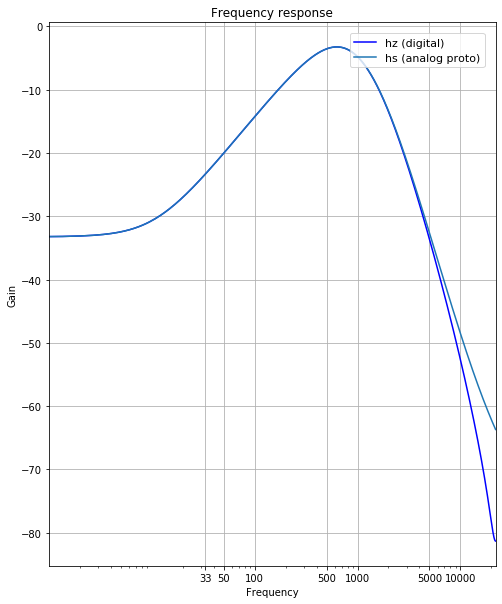

In [2]:
# biquad フィルタのみで構成する場合
network = [
    [
        [1, 90, 1],
        [46, 90, 46]
    ],
    [
        [0, 1, 20],
        [0, 11, 20]
    ],
    [
        [0, 1, 20],
        [0, 23, 20]
    ]
]

# 4次のIIRフィルタ
network = [
    [
        [1, 130, 4001, 36040, 400],
        [11638, 54050, 91238, 67280, 18400]
    ]
]

filters = []

for (num, den) in network:
    num = [ x * ( (2 * np.pi * 1000)**-(4-i) ) for i, x in enumerate(num) ]
    den = [ x * ( (2 * np.pi * 1000)**-(4-i) ) for i, x in enumerate(den) ]

    filtz = signal.lti(*signal.bilinear(num, den, sr))
    wz, hz = signal.freqz(filtz.num, filtz.den, worN=2**15)
    ws, hs = signal.freqs(num, den, worN=sr*wz)
    filters.append({
        "filter": filtz,
        "wz": wz,
        "hz": hz,
    })

    plt.figure(figsize=(8,10))
    plt.title("Frequency response")
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Gain')
    plt.xlabel('Frequency')
    #plt.ylim((0, 70))
    plt.xlim((33, 10000))
    plt.xlim((1, sr/2))
    plt.xticks(xticks, xticks)

    freqz_dB = 20 * np.log10(np.abs(hz))
    expected_dB =  -20 * np.log10(loss_m)

    plt.plot(wz*sr/(2*np.pi), 20 * np.log10(np.abs(hz)), 'b', label="hz (digital)")
    plt.plot(wz*sr/(2*np.pi), 20 * np.log10(np.abs(hs)), label="hs (analog proto)")
    #plt.plot(f_m, -20 * np.log10(loss_m), label="expected")

    error = np.abs(freqz_dB- expected_dB)
    print('Max Error', np.max(error), 'dB', 'at', wz[np.argmax(error)]*sr/(2*np.pi), 'Hz')
    print('MSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

    plt.show()

# FIR フィルタで補正する

双一次変換の IIR フィルタには誤差が残るので、これを FIR フィルタで補正する。
まず補正する周波数特性を算出する

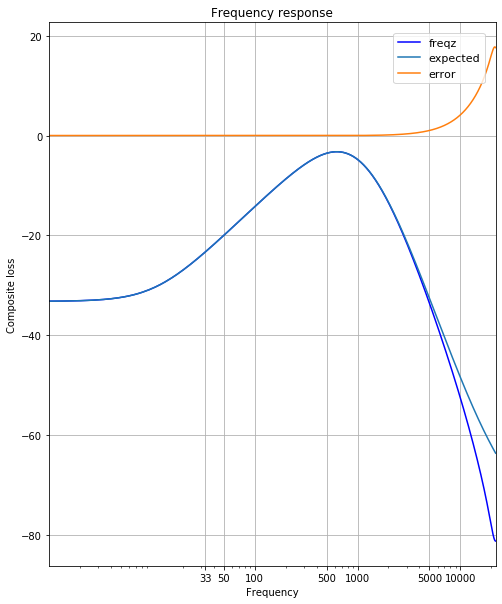

In [3]:
h =  np.multiply.reduce([ np.abs(f["hz"]) for f in filters])
x = filters[0]["wz"]*sr/(2*np.pi)
diff =   -20 * np.log10(loss_m) - 20 * np.log10(np.abs(h))
diff = np.power(10, diff / 20)
plt.figure(figsize=(8,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
#plt.ylim((-100, 0))
#plt.xlim((33, 10000))
plt.xlim((1, sr/2))
plt.xticks(xticks, xticks)
plt.plot(x, 20 * np.log10(np.abs(h)), 'b', label="freqz")
plt.plot(f_m, -20 * np.log10(loss_m), label="expected")
plt.plot(f_m, 20 * np.log10(diff), label="error")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

実数フィルタにするため、左右対称にして IFFT してインパルスレスポンスを得る

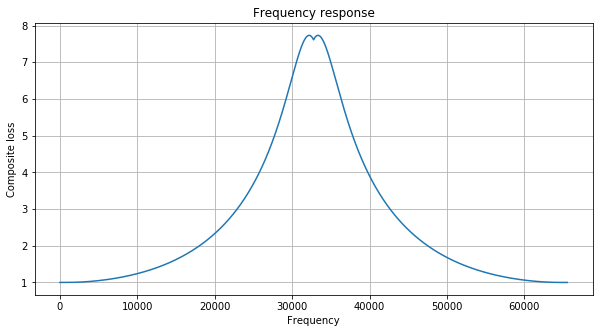

129


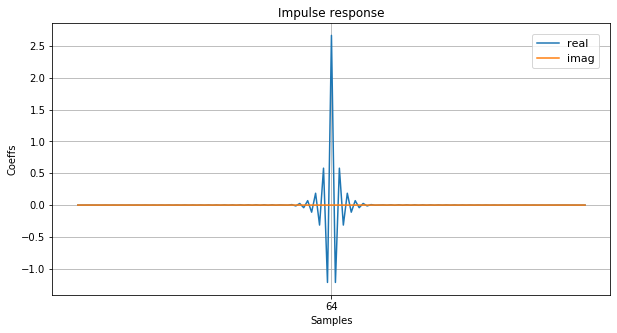

In [4]:
gain = list(diff) + list(diff[::-1])
plt.figure(figsize=(10,5))
plt.title("Frequency response")
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
plt.plot(gain)
plt.show()
fir = np.fft.ifft(gain)
fir = list(fir[:65])
fir = list(fir[::-1]) + list(fir[1:])
print(len(fir))

x = np.linspace(0, len(fir)-1, len(fir))
plt.figure(figsize=(10,5))
plt.title("Impulse response")
plt.grid(True)
plt.ylabel("Coeffs")
plt.xlabel("Samples")
plt.plot(x, np.real(fir), label="real")
plt.plot(x, np.imag(fir), label="imag")
plt.xticks([64], [64])
#plt.xlim((60,68))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

fir = np.real(fir)

# IIR + FIR の合成特性を評価する

IIR と補正 FIR を組合せて、誤差を評価する。

Max Error 0.04974724191783508 dB at 22049.327087402344 Hz
MSE 0.0019852001730218663 dB


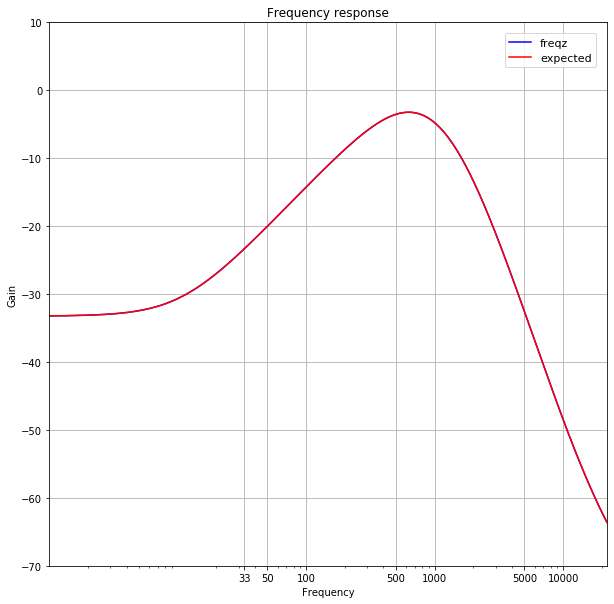

In [5]:
w, h = signal.freqz(fir, worN=2**15)

x = w * sr * 1.0 / (2 * np.pi)
plt.figure(figsize=(10,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.xlim((1, sr/2))
plt.ylim((-70, 10))
plt.xticks(xticks, xticks)

h =  np.multiply.reduce([ np.abs(f["hz"]) for f in filters]) * np.abs(h)

freqz_dB = 20 * np.log10(h)
expected_dB = -20 * np.log10(loss_m)
plt.plot(x, freqz_dB, 'b', label="freqz")
plt.plot(f_m, expected_dB, 'r', label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

error = np.abs(freqz_dB- expected_dB)
print('Max Error', np.max(error), 'dB', 'at', wz[np.argmax(error)]*sr/(2*np.pi), 'Hz')
print('MSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

In [6]:
data = [
  {
       "num": list(f["filter"].num),
       "den":  list(f["filter"].den),
   }
    for f in filters
]
data.append(list(fir))

print(json.dumps(data, indent=2))

[
  {
    "num": [
      0.0027293620390779223,
      0.0002239451280681405,
      -0.002162405616471103,
      -0.0007195307151076326,
      -6.105389511747936e-05
    ],
    "den": [
      1.0,
      -3.3926835929532446,
      4.312959033230201,
      -2.4347384558596867,
      0.5149375948434236
    ]
  },
  [
    -0.00034784079278272323,
    0.0003591057488314103,
    -0.0003708374974680204,
    0.00038327793286990774,
    -0.0003961992795673755,
    0.00040998765931574057,
    -0.00042426286213959367,
    0.0004396050209241594,
    -0.00045542725478700107,
    0.00047257041956135095,
    -0.0004901681025685529,
    0.0005094111811268226,
    -0.0005290559939055738,
    0.0005507628426983048,
    -0.0005727799686419488,
    0.0005973965867091121,
    -0.0006221778700522442,
    0.0006502547671927673,
    -0.0006782756914777643,
    0.0007104970512691832,
    -0.0007423386638185915,
    0.0007795603458064944,
    -0.0008159374296345036,
    0.0008592362492915234,
    -0.000901033003